# Validation

In [1]:
import os
import util.util_validation as ut_val
from util.util_logging import open_csv_file, create_tsne_md, create_run_md, create_cm_md

### Parameters

In [3]:
keep_params_dict = {"dataset": "animals10_diff_-1+8000"}
models_dict, df_modelNames = ut_val.collect_models_dict(epoch="last", dataset_classifier="ignore", keep_params_dict=keep_params_dict)
print(df_modelNames.to_markdown(index=False))

| model_name                                 |
|:-------------------------------------------|
| CE_animals10_diff_-1+8000_allAug           |
| SupCon_animals10_diff_-1+8000_cAugSameSAug |


In [7]:
cuda_device = 2
tsenecuda_venv = "/home/tgottwald/tsnecuda_venv/"

root_model = models_dict["SupCon_animals10_diff_-1+8000_cAugSameSAug"][0]

dataset_classifier = ""

dataset_val = "animals10_diff_-1"
dataset_val_2 = "animals10_diff_8000"


tsenecuda_venv_lib64 = os.path.join(tsenecuda_venv, "lib64")
tsenecuda_venv_interpreter = os.path.join(tsenecuda_venv, "bin/python")

root_train, root_test = ut_val.get_root_dataset(dataset_val)

if dataset_val_2:
    root_train_2, root_test_2 = ut_val.get_root_dataset(dataset_val_2)
    path_folder, path_embeddings, path_embeddings_2, epoch = ut_val.get_paths_from_model_checkpoint(root_model, dataset_val, dataset_val_2)
else:
    path_folder, path_embeddings, epoch = ut_val.get_paths_from_model_checkpoint(root_model, dataset_val)

params = open_csv_file(os.path.join(path_folder, "params.csv"))

### Classifier

In [4]:
if 'method' in params:
    if '+' in params["dataset"]:
        dataset_class_1 = params["dataset"].split("+")[0]
        dataset_class_2 = '_'.join(dataset_class_1.split('_')[:-1]) + '_' + params["dataset"].split("+")[-1]

        root_class_train, root_class_test = ut_val.get_root_dataset(dataset_class_1)
        root_class_train_2, _ = ut_val.get_root_dataset(dataset_class_2)

        num_classes = len(ut_val.get_classes(dataset_class_1))
    else:
        root_class_train, root_class_test = ut_val.get_root_dataset(params["dataset"])
        root_class_train_2 = None

        num_classes = len(ut_val.get_classes(params["dataset"]))

    mean = params['mean']
    std = params['std']

    aug_dict = {"sameResizedCrop": "resizedCrop", "sameHorizontalFlip": "horizontalFlip", "sameColorJitter": "colorJitter", "sameGrayscale": "grayscale"}
    aug_str = " ".join([(aug_dict[a] if a in aug_dict else a) for a in params["aug"]])
    resizedCrop_str = " ".join([str(x) for  x in params["resizedCrop"]])
    colorJitter_str = " ".join([str(x) for x in params["colorJitter"]])


    classifier_training_call = f'CUDA_VISIBLE_DEVICES={cuda_device} nohup python main_linear.py'\
                            + f' --batch_size {params["batch_size"]} --batch_size_val {params["batch_size"]} --epochs 30 --learning_rate 0.5 --cosine'\
                            + f' --model {params["model"]} --dataset {params["dataset"]}'\
                            + f' --ckpt {root_model}'\
                            + f' --data_folder {root_class_train} --test_folder {root_class_test} --size {params["size"]}'\
                            + (f' --diff_folder {root_class_train_2} --diff_p 0.5' if root_class_train_2 else '')\
                            + f' --num_classes {num_classes} --mean "{mean}" --std "{std}"'\
                            + f' --aug {aug_str} --resizedCrop {resizedCrop_str} --horizontalFlip {params["horizontalFlip"]}'\
                            + f' --colorJitter {colorJitter_str} --grayscale {params["grayscale"]}'\
                            + f' --tag Epoch{epoch}'\
                            + ' > classifier.out &'

    os.system(classifier_training_call)

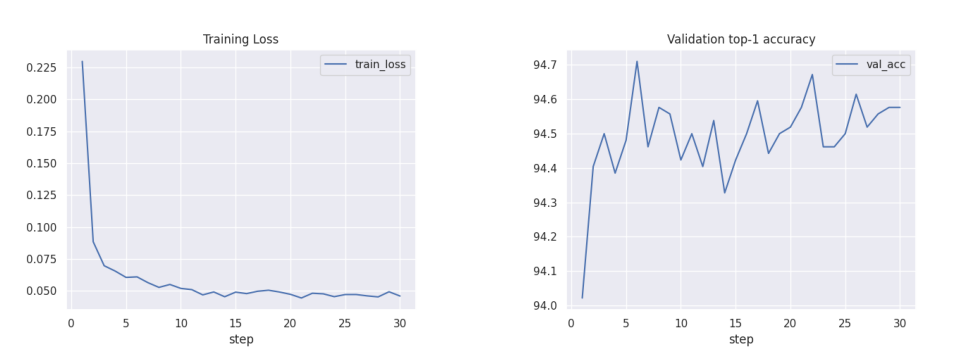

In [5]:
path_classifier = ut_val.get_path_classifier(root_model, dataset_classifier, params)
ut_val.move_classifier_out_file(path_classifier)

ut_val.load_classifier_plots(path_classifier)
create_run_md(path_folder)

#### Use pre computed embeddings for training

This means that no augmentation during training is possible.

In [13]:
classifier_training_call = f"CUDA_VISIBLE_DEVICES={cuda_device} nohup python main_linear.py"\
                          + " --batch_size 256 --batch_size_val 256 --epochs 30 --learning_rate 5"\
                          + f" --model {params['model']} --dataset {params['dataset']}"\
                          + f" --data_folder {os.path.join(path_embeddings, 'embedding_train')}"\
                          + f" --test_folder {os.path.join(path_embeddings, 'embedding_test')}"\
                          + " --num_classes 10 --pre_comp_feat"\
                          + f" --tag Epoch{epoch}"\
                          + (f" --md_file val_{dataset_val}.md" if params['dataset'] != dataset_val else "")\
                          + " > precomp_classifier.out"

if dataset_val_2:
    classifier_training_call_2 = f"CUDA_VISIBLE_DEVICES={cuda_device} nohup python main_linear.py"\
                            + " --batch_size 256 --batch_size_val 256 --epochs 30 --learning_rate 5"\
                            + f" --model {params['model']} --dataset {params['dataset']}"\
                            + f" --data_folder {os.path.join(path_embeddings_2, 'embedding_train')}"\
                            + f" --test_folder {os.path.join(path_embeddings_2, 'embedding_test')}"\
                            + " --num_classes 10 --pre_comp_feat"\
                            + f" --tag Epoch{epoch}"\
                            + (f" --md_file val_{dataset_val_2}.md" if params['dataset'] != dataset_val_2 else "")\
                            + " > precomp_classifier.out"

In [ ]:
os.system(classifier_training_call)

if dataset_val_2:
    os.system(classifier_training_call_2)

In [ ]:
path_classifier = ut_val.get_path_classifier(root_model, dataset_val, params)
ut_val.move_classifier_out_file(path_classifier)

ut_val.load_classifier_plots(path_classifier)

if dataset_val_2:
    path_classifier_2 = ut_val.get_path_classifier(root_model, dataset_val_2, params)
    ut_val.move_classifier_out_file(path_classifier_2)

    ut_val.load_classifier_plots(path_classifier_2)

### Dataloader and Model

In [11]:
train_loader, val_loader = ut_val.set_dataloader(dataset_val, params, root_train, root_test)
if dataset_val_2:
    train_loader_2, val_loader_2 = ut_val.set_dataloader(dataset_val_2, params, root_train_2, root_test_2)

model = ut_val.set_model(root_model, params, cuda_device)

### Compute Embedding

In [12]:
embedding_train, class_labels_train, images_train, embedding_test, class_labels_test, images_test = ut_val.compute_and_save_embeddings(model, train_loader, val_loader, path_embeddings, params, cuda_device)

if dataset_val_2:
    embedding_train_2, class_labels_train_2, images_train_2, embedding_test_2, class_labels_test_2, images_test_2 = ut_val.compute_and_save_embeddings(model, train_loader_2, val_loader_2, path_embeddings_2, params, cuda_device)

100%|██████████| 202/202 [02:09<00:00,  1.55it/s]


### t-SNE

Data split train
load feature embedding
compute t-SNE embedding
writ t-SNE embedding
Data split test
load feature embedding
compute t-SNE embedding
writ t-SNE embedding


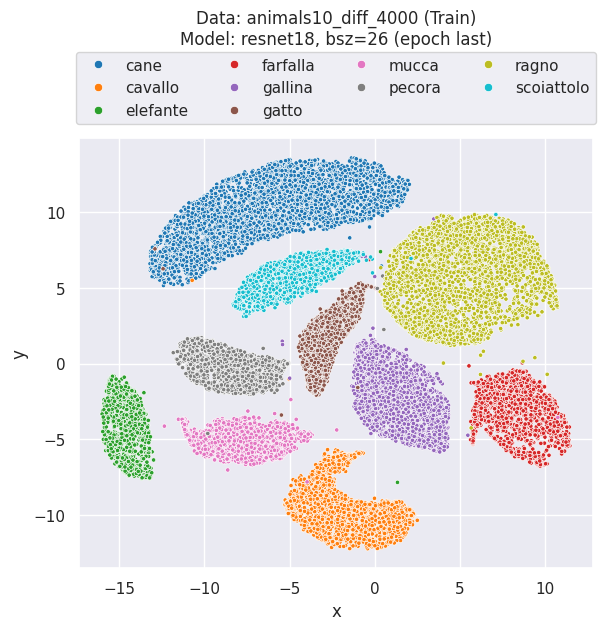

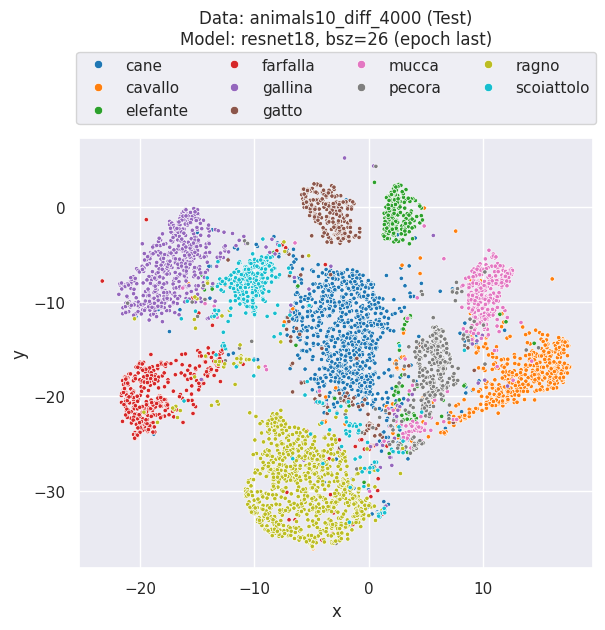

In [13]:
os.system(f"CUDA_VISIBLE_DEVICES={cuda_device} LD_LIBRARY_PATH={tsenecuda_venv_lib64} {tsenecuda_venv_interpreter} compute_tsne.py --path {path_embeddings}")
ut_val.save_tSNE_plots(dataset_val, path_embeddings, params, epoch)

if dataset_val_2:
    os.system(f"CUDA_VISIBLE_DEVICES={cuda_device} LD_LIBRARY_PATH={tsenecuda_venv_lib64} {tsenecuda_venv_interpreter} compute_tsne.py --path {path_embeddings_2}")
    ut_val.save_tSNE_plots(dataset_val_2, path_embeddings_2, params, epoch)

create_tsne_md(path_folder)

### Classifier individual Class Accuracies

animals10_diff_-1
Train: acc=99.93, acc_b=99.93
 Test: acc=94.58, acc_b=93.77

animals10_diff_8000
Train: acc=99.90, acc_b=99.89
 Test: acc=91.14, acc_b=89.91


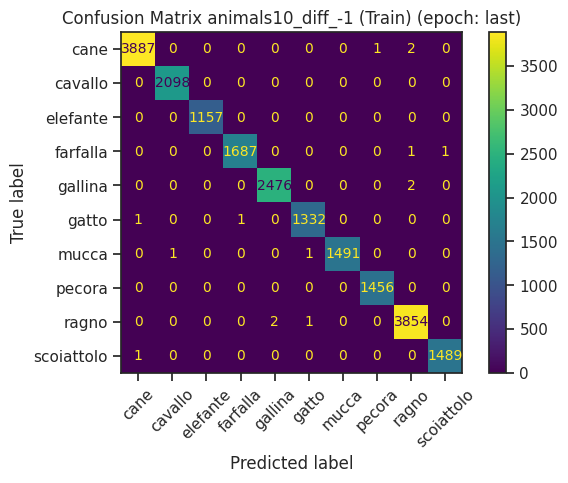

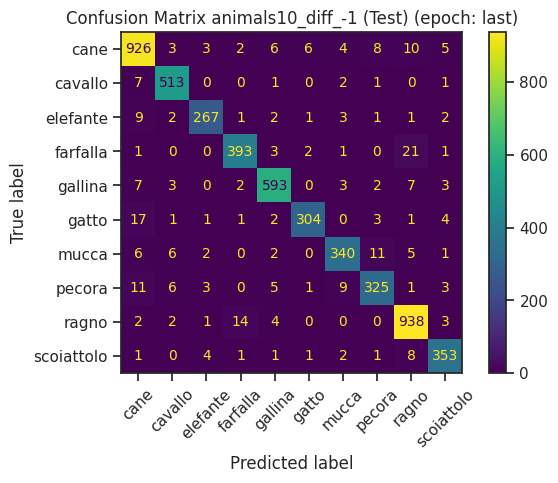

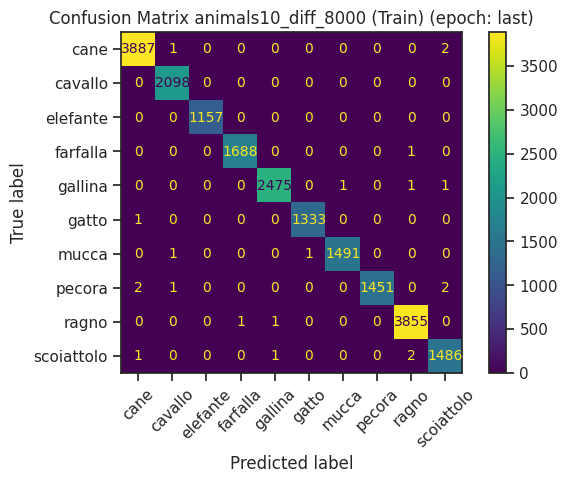

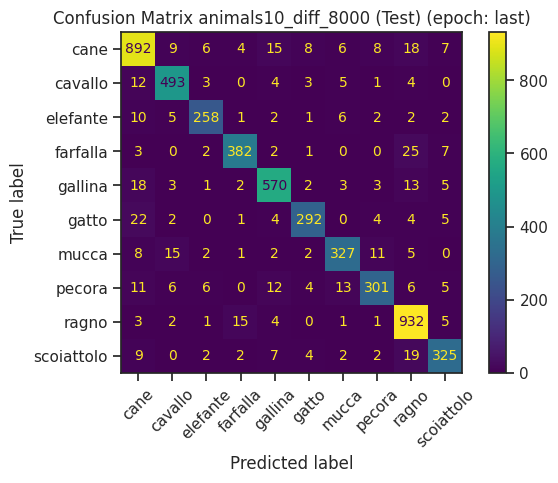

In [8]:
C_train, acc_train, acc_b_train, C_val, acc_val, acc_b_val = ut_val.compute_and_save_confusion_matrix(root_model, dataset_classifier, path_embeddings, params, epoch, cuda_device)

print(dataset_val)
print(f"Train: acc={acc_train*100:.2f}, acc_b={acc_b_train*100:.2f}")
print(f" Test: acc={acc_val*100:.2f}, acc_b={acc_b_val*100:.2f}")

if dataset_val_2:
    C_train_2, acc_train_2, acc_b_train_2, C_val_2, acc_val_2, acc_b_val_2 = ut_val.compute_and_save_confusion_matrix(root_model, dataset_classifier, path_embeddings_2, params, epoch, cuda_device)

    print(f"\n{dataset_val_2}")
    print(f"Train: acc={acc_train_2*100:.2f}, acc_b={acc_b_train_2*100:.2f}")
    print(f" Test: acc={acc_val_2*100:.2f}, acc_b={acc_b_val_2*100:.2f}")

create_cm_md(path_folder)